

# **Synchronization in Complex Networks and Applications**


---





Victor Hugo F. Francheto

University of São Paulo, SP

victor.francheto@usp.br



Bruno B. Pereira

University of São Paulo, SP

bruno.pereira@usp.br


---



**Tema escolhido:**

### **5 - Como a sincronização é inPuenciada pela topologia da rede?**

Ver: https://github.com/fabridamicelli/kuramoto

Use o artigo:
Synchronization in complex networks
https://www.sciencedirect.com/science/ar;cle/pii/S0370157308003384

Gerar redes usando diferentes modelos e verificar como a sincronização muda de acordo com o
modelo. Pode ser gerado um gráfico do parâmetro de ordem (r) em função do acomplamento
lambda.

Analisar como a estrutura de comunidades afeta a sincronização, mudando o parâmetro mu no
modelo de LFR que gera redes modulares.

---

Iniciamos importando os pacotes basicos para o estudo.

In [183]:
from pylab import *
import numpy as np
from numpy import linalg as LA
from scipy.integrate import *
import matplotlib.pyplot as plt
from scipy.special import zeta
import networkx as nx
import community.community_louvain as community_louvain

Para estudar a sincronização em diferentes topologias, utilizaremos o modelo de Kuramoto.

In [184]:
# First-order Kuramoto model
def F(Y,t, G, W, lbd):
    #global W, N, lbd, G
    N = len(G.nodes())
    F = zeros((N),float)
    S = zeros((N),float)
    dg = G.degree()
    for i in range(0,N):
        for j in G.neighbors(i):
            S[i] = S[i] + sin(Y[j]-Y[i]) #
    ld = lbd
    F = W + ld*S #traditional Kuramoto
    return F

Aqui estamos definindo alguns paramentros das redes que analizaremos a sincronização.

In [185]:
#>>Parametros de Rede<<#

#Número de nós
N = 150

# Grau médio
av_degree = 6

# Probabilidade de conexão para Modelos Erdős–Rényi
p = float(av_degree)/float(N)

# Número de nós incluídos a cada passo de tempo no modelo Barabasi Albert e Waxman
m = int(av_degree/2)

# Número de vizinhos no modelo Small Words
kappa = av_degree

#>>Paremetros de redes com comunidades<<#

# Definir tamanhos das partições (comunidades)
partition_sizes = [30, 30, 20]

# Probabilidade de aresta dentro da mesma comunidade
p_in = 0.5

# Probabilidade de aresta entre comunidades diferentes
p_out = 0.02

seed = 42


#>>Paremetros de redes com comunidades LFV<<#
tau1 = 2
tau2 = 2
mu = 0.1
minc = 20
maxc = 200



In [186]:

def rede_com_comunidades(partition_sizes,p_in,p_out,seed):

  # Definir tamanhos das partições (comunidades)
  partition_sizes = partition_sizes

  # Definir probabilidades de conexão
  p_in = p_in  # Probabilidade de aresta dentro da mesma comunidade
  p_out = p_out # Probabilidade de aresta entre comunidades diferentes

  # Gerar o grafo particionado aleatório
  G = nx.random_partition_graph(partition_sizes, p_in, p_out, seed=seed)
  return G




In [187]:
def rede_com_comunidades_LFR(N, tau1, tau2, mu, k, minc, maxc):
  N = N
  tau1 = tau1
  tau2 = tau2
  mu = mu
  k = k
  minc = minc
  maxc = maxc
  G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k,
                          max_degree = k, min_community=minc, max_community = maxc, seed = 10)
  return G

In [188]:
def rede_eros_renie(N,p,seed):
  N = N
  p = p
  seed = seed
  G = nx.gnp_random_graph(N, p, seed=seed, directed=False)
  return G

In [189]:
def rede_small_word(N, k, p, seed):
  N = N
  k = k
  p = p
  seed = seed
  k = int(k)
  G = nx.watts_strogatz_graph(N, k, p, seed=seed)
  return G


In [190]:
def rede_barabasi_albert(N,m):
   m = m
   G = nx.barabasi_albert_graph(N, m)
   return G

In [211]:
def rede_waxman(N,seed):
   seed = seed
   G = nx.waxman_graph(N, seed=seed)
   return G

In [192]:
def imagem_rede(G):
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  G = nx.convert_node_labels_to_integers(G, first_label=0)
  pos = nx.spring_layout(G)
  return nx.draw(G, pos, node_color="c", node_size=10, with_labels=False)

In [193]:

def calculando_sincronizacao(G):
  G = G.to_undirected() # Remevendo direção da Rede
  G = nx.convert_node_labels_to_integers(G, first_label=0) # Convertendo os Labels em inteiros
  N = len(G) # Número de Nós

  vk = dict(G.degree()) # Grau
  vk = list(vk.values()) # ??
  av_k = mean(vk) # Grau Médio

  A = nx.adjacency_matrix(G) #Criando matriz de adjacencia
  A = A.todense() #ajustando a matrix
  eig, vectors = LA.eig(A) # Calculando auto valores
  lambda_max = eig.max() # Obtendo o maior auto valor

  #>>Initial phases<<#
  w0 = np.pi
  y0 = np.random.normal(0, w0, size = N)

  # Frequência Natural
  W = np.random.uniform(-w0, w0, size = N)

  # Acoplamento Crítico
  hist, bin_edges = np.histogram(W, density=True)
  g0 = max(hist)
  lambda_c = 2/(np.pi*lambda_max*g0)

  # Tempo de Integração
  t0 = 0.0  # Inicio
  h = 0.02 # Incremento
  Np = 3000 # Numero de interações
  tStop = int(Np*h) # Fim da Integração
  t = linspace(t0,tStop,Np)

  #>>Processo de Sincronização<<#
  vlbd = []  # vetor que armazena a força de acoplamento
  aux = 0
  Ns = 1 # Numero de Simulações
  vlbd = np.arange(0, 10*lambda_c, lambda_c/5) #variation of the coupling strength
  mvr = np.zeros(shape=shape(vlbd))
  for s in arange(0,Ns):
      vr = []  # vector that stores the order parameter
      for lbd in vlbd:
          y = odeint(F, y0, t, (G, W, lbd))
          y = np.array(y)
          y = y[range(len(y)-round(0.9*len(y)),len(y)),:]
          y = y.mean(0)
          psi = mean(y)
          r = abs((1.0/N)*sum(np.exp(1j*y)))
          vr.append(r)
          aux = aux + 1
          #print(aux, ": ", lbd, r)
          y0 = y # adiabatic increase
      mvr = mvr + vr
  mvr = mvr/Ns
  vlbd = array(vlbd, dtype=float)
  if len(mvr) != len(vlbd):
    min_length = min(len(vlbd), len(mvr))
    vlbd = vlbd[:min_length]
    mvr = mvr[:min_length]

  return vlbd,mvr,lambda_c




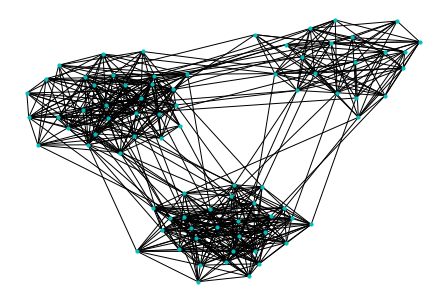

In [194]:
G_1 = nx.Graph()
G_1 = rede_com_comunidades(partition_sizes,p_in,p_out,seed)
vlbd_1,mvr_1,lambda_c = calculando_sincronizacao(G_1)

imagem_rede(G_1)

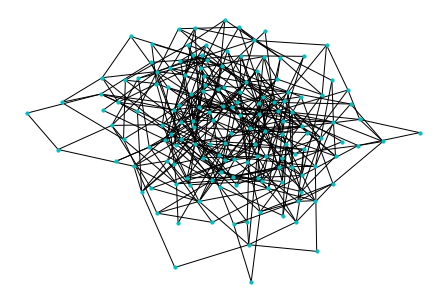

In [195]:
G_2 = nx.Graph()
G_2 = rede_eros_renie(N,p,seed)
vlbd_2,mvr_2,lambda_c = calculando_sincronizacao(G_2)
imagem_rede(G_2)

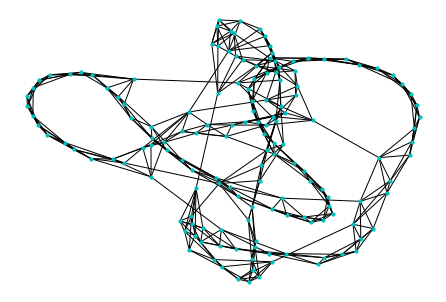

In [196]:
G_3 = nx.Graph()
G_3 = rede_small_word(N, kappa, p, seed)
vlbd_3,mvr_3,lambda_c = calculando_sincronizacao(G_3)
imagem_rede(G_3)

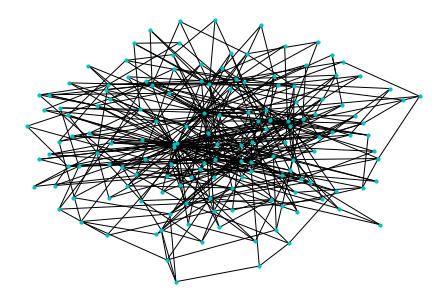

In [197]:
G_4 = nx.Graph()
G_4 = rede_barabasi_albert(N,m)
vlbd_4,mvr_4,lambda_c = calculando_sincronizacao(G_4)
imagem_rede(G_4)

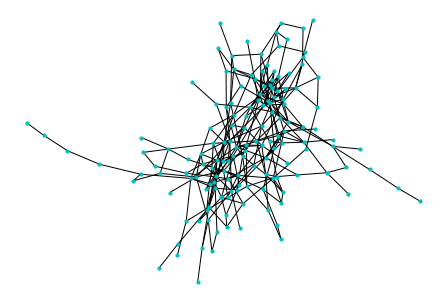

In [212]:
G_5 = nx.Graph()
G_5 = rede_waxman(N,seed)
vlbd_5,mvr_5,lambda_c = calculando_sincronizacao(G_5)
imagem_rede(G_5)

In [199]:
G_6 = nx.Graph()
G_6 = rede_com_comunidades_LFR(N, tau1, tau2, mu, kappa, minc, maxc)
vlbd_6,mvr_6,lambda_c = calculando_sincronizacao(G_6)
imagem_rede(G_6)

KeyboardInterrupt: 

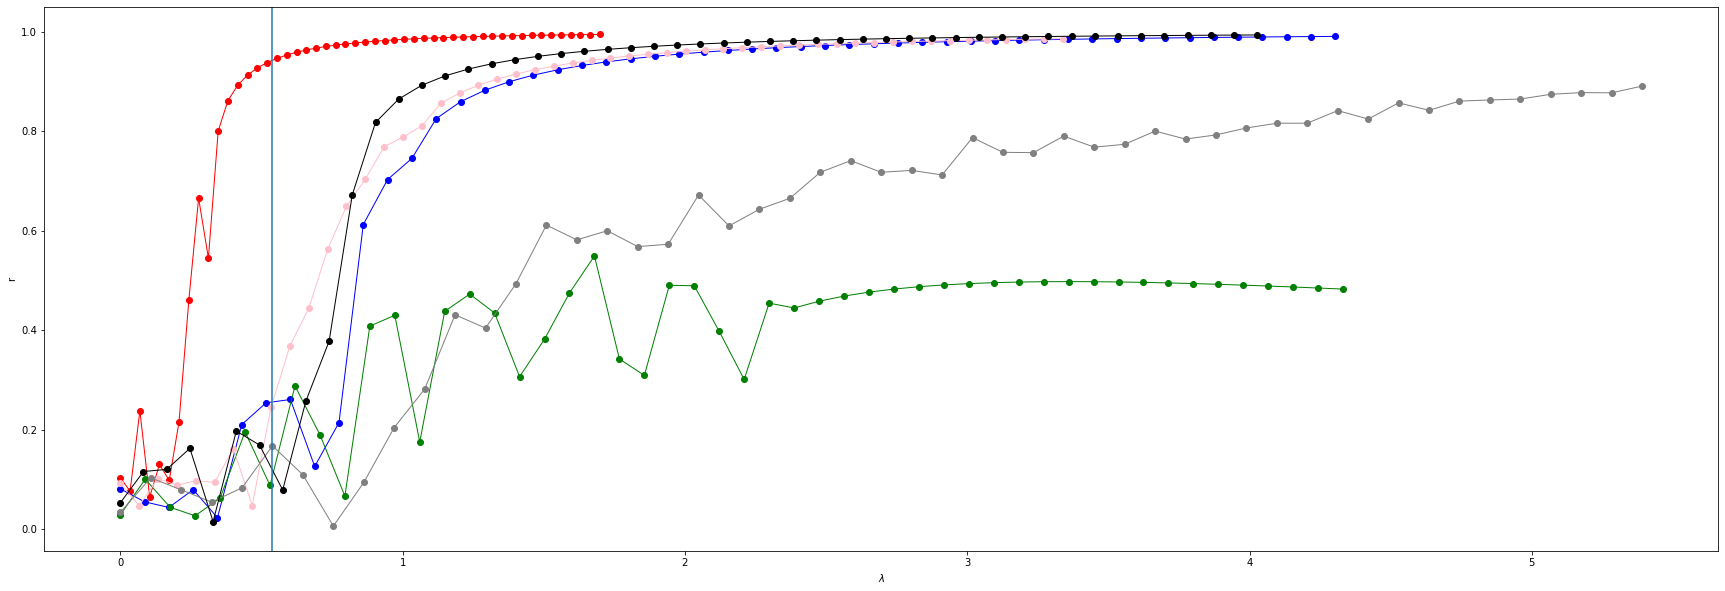

In [213]:
# show the results

plt.figure(figsize=(30,10))
plt.plot(vlbd_1, mvr_1, '-o', color='red', linewidth=1 ) # Com Comunidades
plt.plot(vlbd_2, mvr_2, '-o', color='blue', linewidth=1 ) # ER
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1 ) # SW
plt.plot(vlbd_4, mvr_4, '-o', color='pink', linewidth=1 ) # BA
plt.plot(vlbd_5, mvr_5, '-o', color='gray', linewidth=1 ) # WX
plt.plot(vlbd_6, mvr_6, '-o', color='black', linewidth=1 ) # LFR


plt.axvline(x =lambda_c)
xlabel(r"$\lambda$")
ylabel("r")
#plt.legend(True)
plt.plot(True)

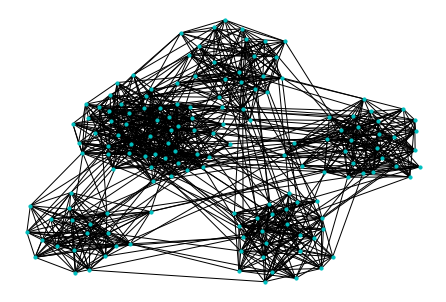

In [201]:
G_8 = nx.Graph()
G_8 = rede_com_comunidades_LFR(N, tau1, tau2, 0.05, kappa*2, minc, maxc)
vlbd_8,mvr_8,lambda_c = calculando_sincronizacao(G_8)
imagem_rede(G_8)

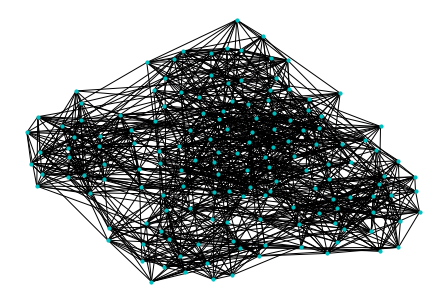

In [202]:
G_9 = nx.Graph()
G_9 = rede_com_comunidades_LFR(N, tau1, tau2, 0.15, kappa*2, minc, maxc)
vlbd_9,mvr_9,lambda_c = calculando_sincronizacao(G_9)
imagem_rede(G_9)

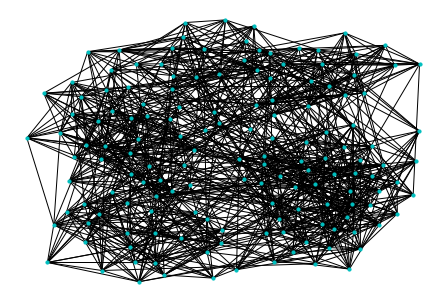

In [204]:
G_10 = nx.Graph()
G_10 = rede_com_comunidades_LFR(N, tau1, tau2, 0.2, kappa*2, minc, maxc)
vlbd_10,mv_10,lambda_c = calculando_sincronizacao(G_10)
imagem_rede(G_10)

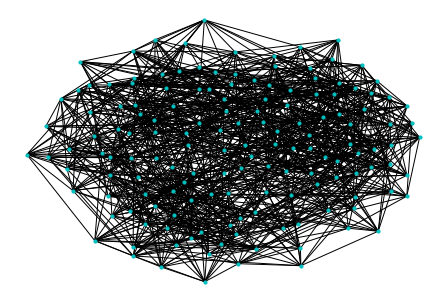

In [205]:
G_11 = nx.Graph()
G_11 = rede_com_comunidades_LFR(N, tau1, tau2, 0.25, kappa*2, minc, maxc)
vlbd_11,mvr_11,lambda_c = calculando_sincronizacao(G_11)
imagem_rede(G_11)

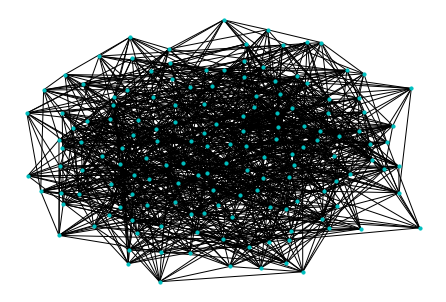

In [206]:
G_12 = nx.Graph()
G_12 = rede_com_comunidades_LFR(N, tau1, tau2, 0.3, kappa*2, minc, maxc)
vlbd_12,mvr_12,lambda_c = calculando_sincronizacao(G_12)
imagem_rede(G_12)

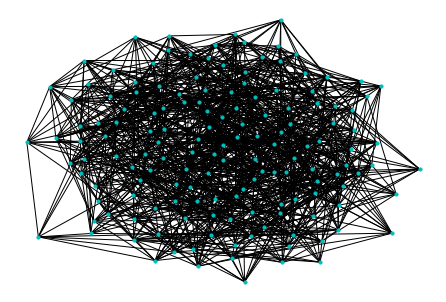

In [207]:
G_13 = nx.Graph()
G_13 = rede_com_comunidades_LFR(N, tau1, tau2, 0.35, kappa*2, minc, maxc)
vlbd_13,mvr_13,lambda_c = calculando_sincronizacao(G_13)
imagem_rede(G_13)

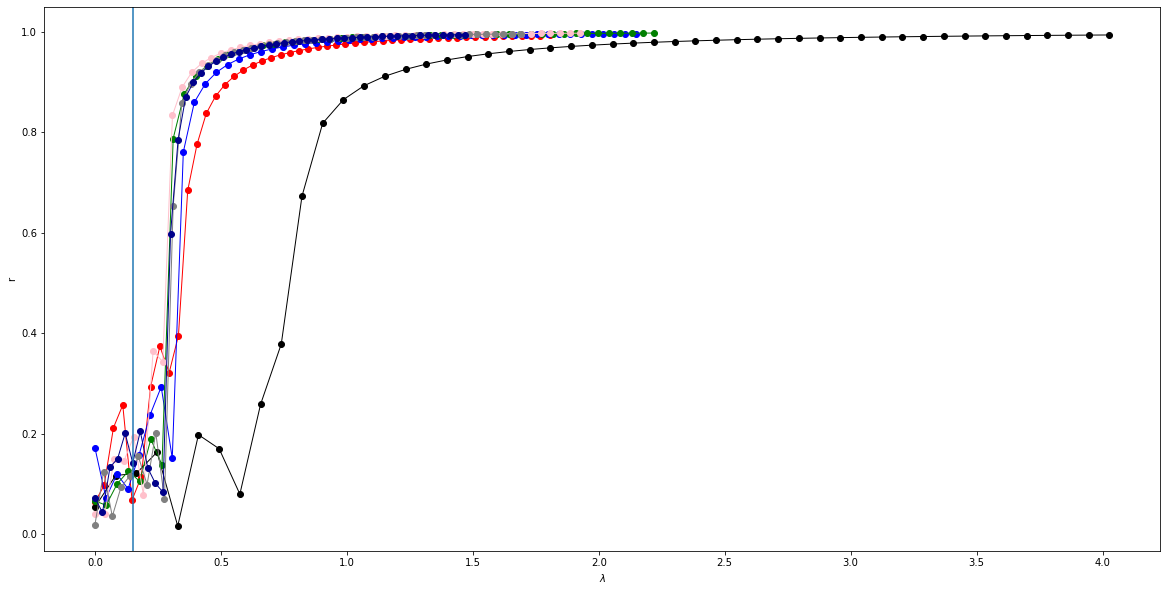

In [208]:
plt.figure(figsize=(20,10))


plt.plot(vlbd_8, mvr_8, '-o', color='red', linewidth=1 ) # LFR MU = 0.05
plt.plot(vlbd_6, mvr_6, '-o', color='black', linewidth=1 ) # LFR MU = 0.1
plt.plot(vlbd_9, mvr_9, '-o', color='blue', linewidth=1 ) # LFR MU = 0.15
plt.plot(vlbd_10, mv_10, '-o', color='green', linewidth=1 ) # LFR MU = 0.2
plt.plot(vlbd_11, mvr_11, '-o', color='pink', linewidth=1 ) # LFR MU = 0.25
plt.plot(vlbd_12, mvr_12, '-o', color='gray', linewidth=1 ) # LFR MU = 0.3
plt.plot(vlbd_13, mvr_13, '-o', color='darkblue', linewidth=1 ) # LFR MU = 0.35



plt.axvline(x =lambda_c)
xlabel(r"$\lambda$")
ylabel("r")
#plt.legend(True)
plt.plot(True)